In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [46]:
df = pd.read_csv('Tweets.csv')
df.shape

(14640, 15)

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
# let's check unique values
columns=df.columns
for col in columns:
    print(col,':\n',df[col].unique())
    print(df[col].value_counts())
    print('\n',20*'**','\n')

tweet_id :
 [570306133677760513 570301130888122368 570301083672813571 ...
 569587242672398336 569587188687634433 569587140490866689]
570290034009636865    2
570305234838429696    2
570299824760860672    2
570300177367633921    2
570300262302289920    2
                     ..
569690786180132865    1
569689297084919808    1
569689184958595072    1
569688749208178688    1
569587140490866689    1
Name: tweet_id, Length: 14485, dtype: int64

 **************************************** 

airline_sentiment :
 ['neutral' 'positive' 'negative']
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

 **************************************** 

airline_sentiment_confidence :
 [1.     0.3486 0.6837 ... 0.6384 0.7094 0.3487]
1.0000    10445
0.6667       71
0.6632       35
0.6596       30
0.6559       30
          ...  
0.3674        1
0.6155        1
0.3708        1
0.6905        1
0.3487        1
Name: airline_sentiment_confidence, Length: 1023, dtype: int64

 ****

In [8]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [9]:
df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

array([[<AxesSubplot:title={'center':'tweet_id'}>,
        <AxesSubplot:title={'center':'airline_sentiment_confidence'}>],
       [<AxesSubplot:title={'center':'negativereason_confidence'}>,
        <AxesSubplot:title={'center':'retweet_count'}>]], dtype=object)

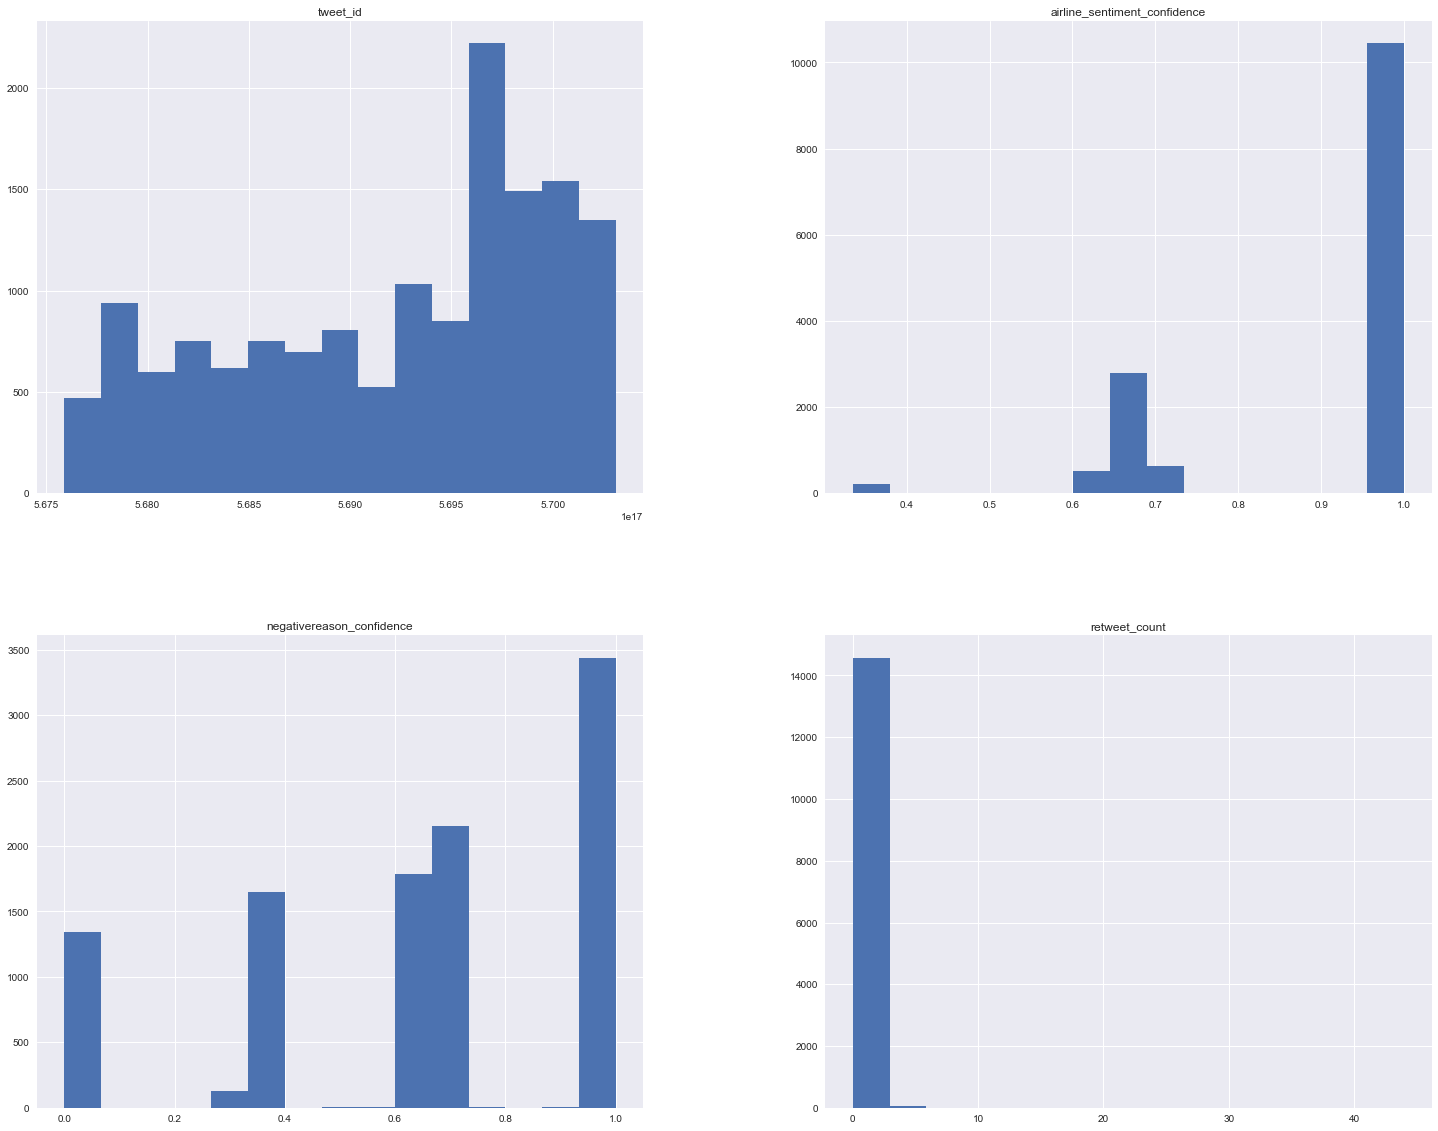

In [10]:
plt.style.use("seaborn")
df.hist(figsize=(25,20), bins=15)

In [11]:
# Unique values of sentiment
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [12]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

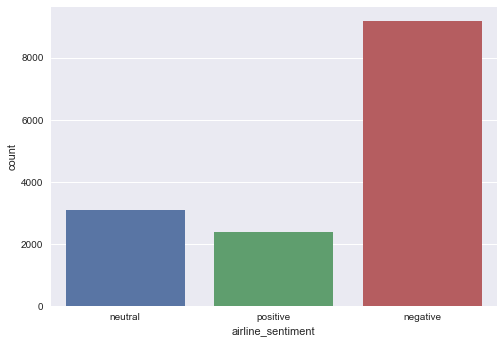

In [13]:
sns.countplot(x="airline_sentiment", data=df)

<AxesSubplot:ylabel='airline_sentiment'>

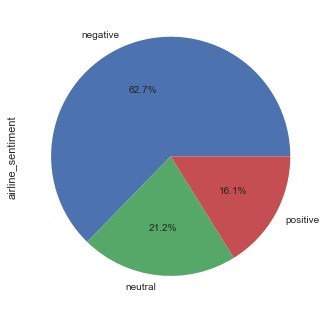

In [14]:
df['airline_sentiment'].value_counts().plot(kind='pie',autopct='%1.1f%%')

In [15]:
# Unique values of sentiment
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

<AxesSubplot:xlabel='airline', ylabel='count'>

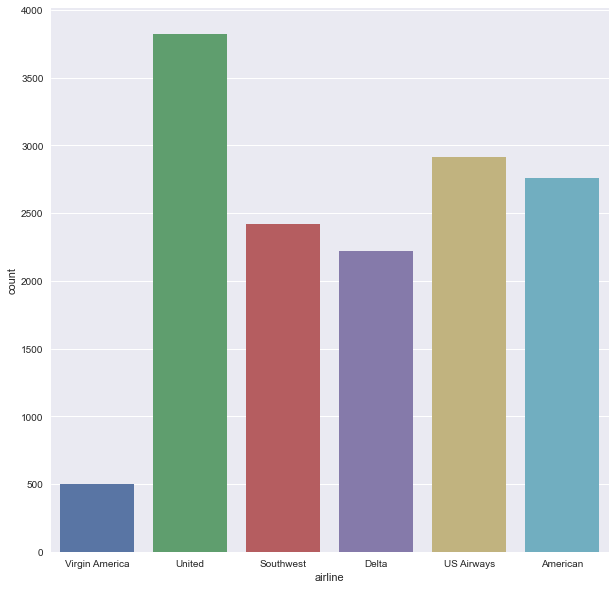

In [16]:
plt.figure(figsize=(10,10))
sns.countplot(x="airline", data=df)

<AxesSubplot:ylabel='airline'>

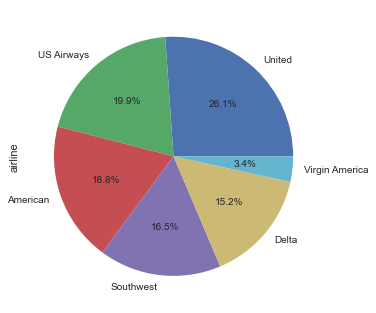

In [17]:
df['airline'].value_counts().plot(kind='pie',autopct='%1.1f%%')

In [18]:
df['retweet_count'].value_counts()

0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
28        1
9         1
18        1
11        1
31        1
15        1
44        1
Name: retweet_count, dtype: int64

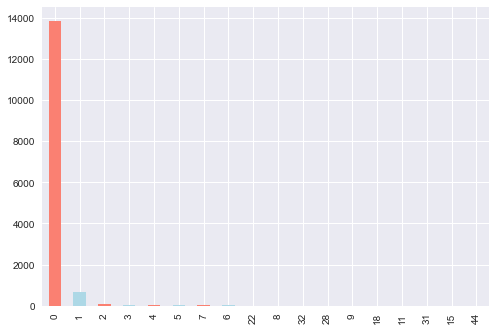

In [19]:
df["retweet_count"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [20]:
pd.crosstab(df.airline, df.airline_sentiment)

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


<AxesSubplot:xlabel='airline'>

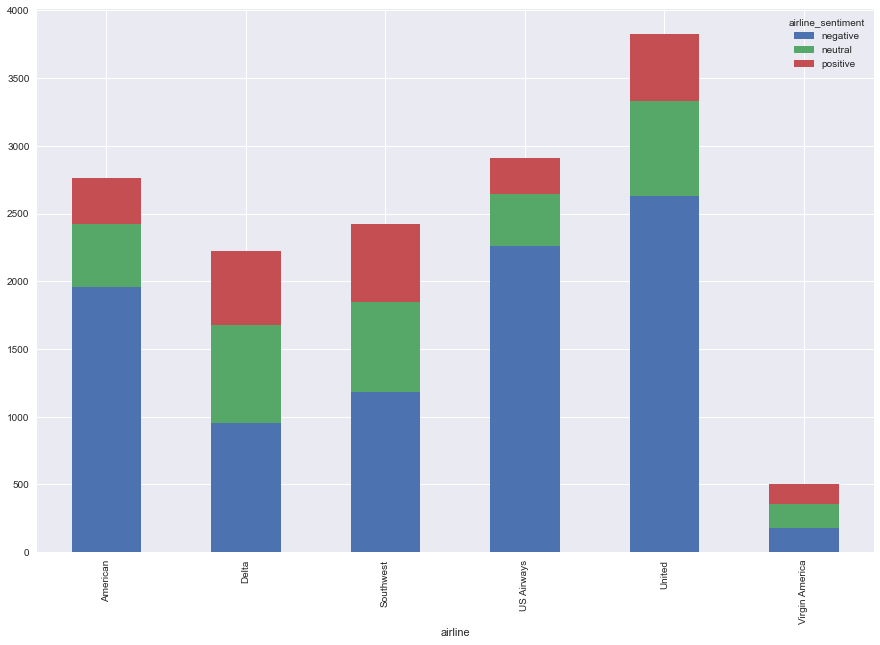

In [21]:
figure_2 = df.groupby(['airline', 'airline_sentiment']).size()
figure_2.unstack().plot(kind='bar', stacked=True, figsize=(15,10))

In [22]:
pd.crosstab(df.airline, df.negativereason)

negativereason,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
airline,,,,,,,,,,
American,87,198,246,768,12,87,130,249,149,34
Delta,64,186,51,199,11,60,44,269,57,14
Southwest,90,159,162,391,14,38,61,152,90,29
US Airways,104,246,189,811,11,123,122,453,154,50
United,216,379,181,681,22,168,144,525,269,48
Virgin America,19,22,18,60,4,5,28,17,5,3


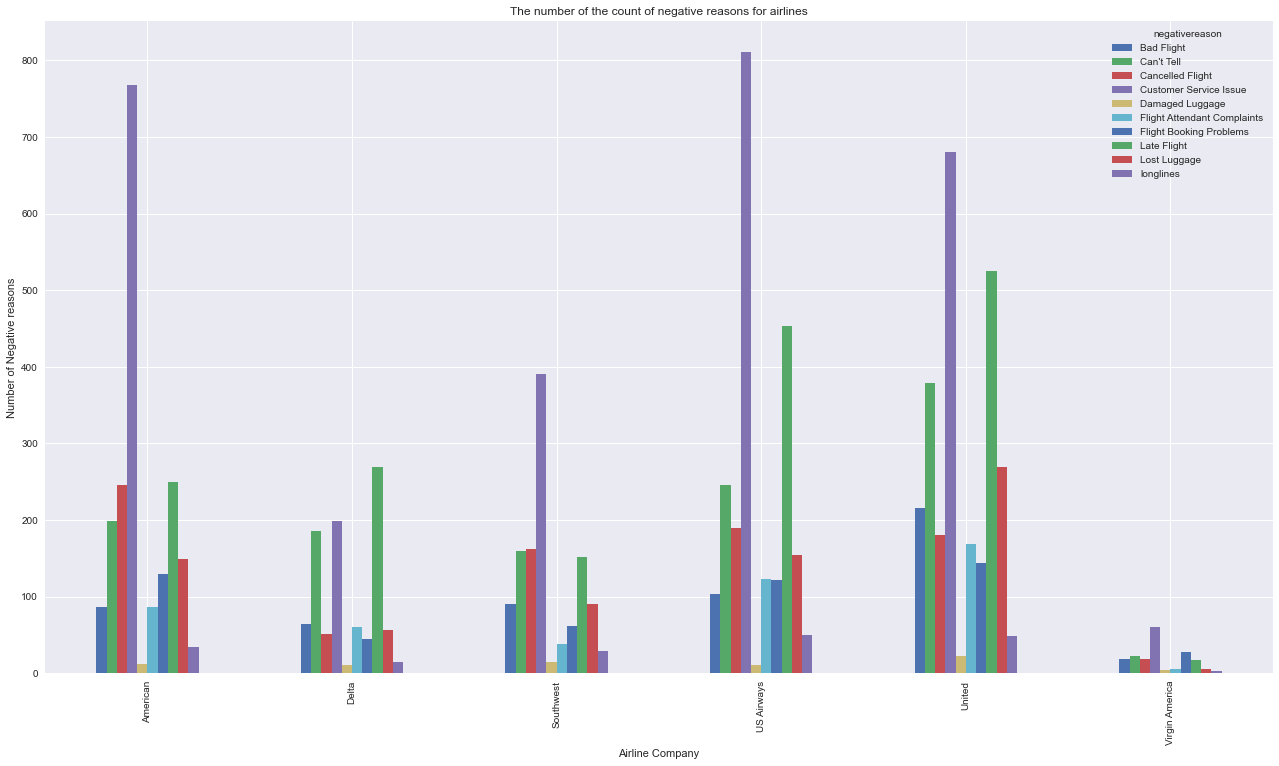

In [23]:
negative_reasons = df.groupby('airline')['negativereason'].value_counts(ascending=True)
negative_reasons.groupby(['airline','negativereason']).sum().unstack().plot(kind='bar',figsize=(22,12))
plt.xlabel('Airline Company')
plt.ylabel('Number of Negative reasons')
plt.title("The number of the count of negative reasons for airlines")
plt.show()

In [24]:
df.corr()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
tweet_id,1.000000,0.024840,0.021533,-0.008852
airline_sentiment_confidence,0.024840,1.000000,0.685879,0.012581
negativereason_confidence,0.021533,0.685879,1.000000,0.021574
retweet_count,-0.008852,0.012581,0.021574,1.000000


(4.5, -0.5)

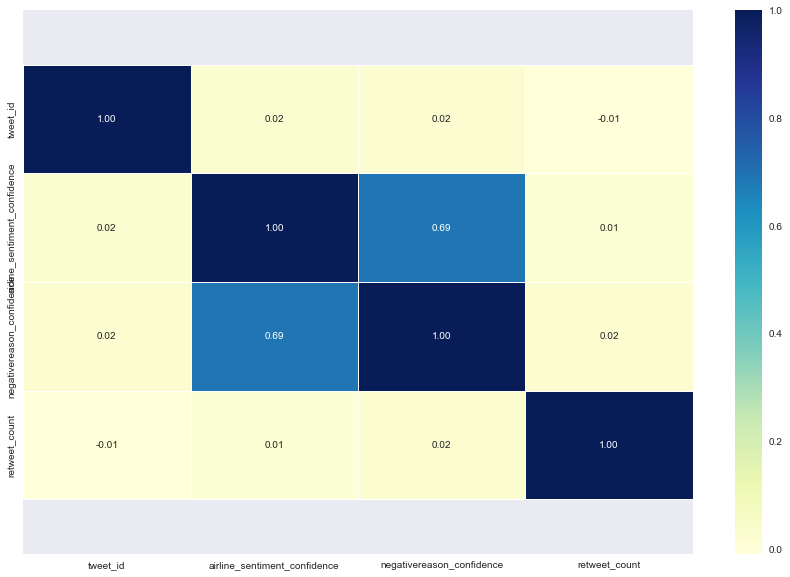

In [25]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


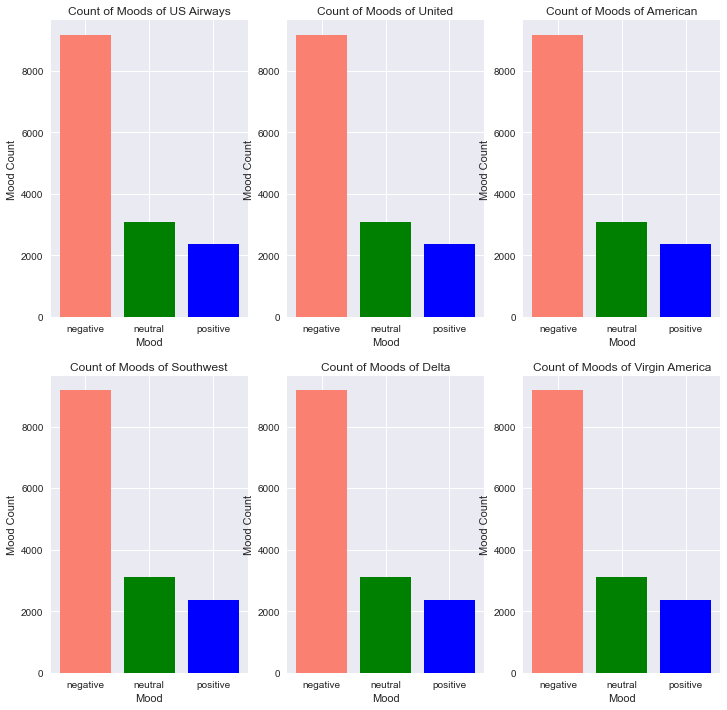

In [30]:
print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['salmon', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

            Percent Negative
American            0.710402
Delta               0.429793
Southwest           0.490083
US Airways          0.776862
United              0.688906
Virgin              0.359127


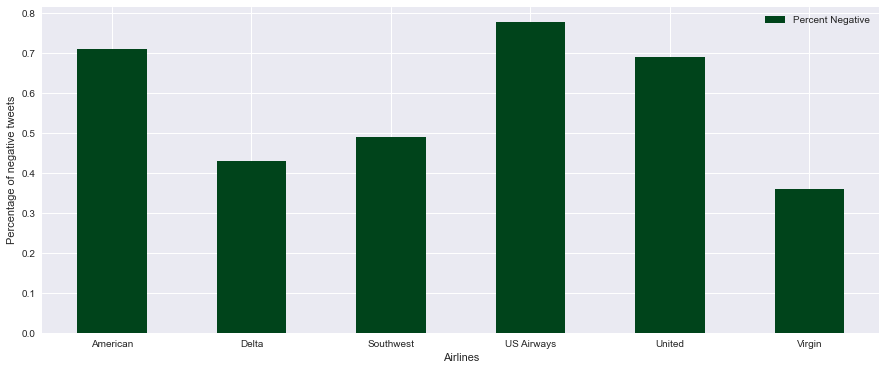

In [35]:
neg_tweets = df.groupby(['airline','airline_sentiment']).count().iloc[:,0]
total_tweets = df.groupby(['airline'])['airline_sentiment'].count()

my_dict = {'American':neg_tweets[0] / total_tweets[0],'Delta':neg_tweets[3] / total_tweets[1],'Southwest': neg_tweets[6] / total_tweets[2],
'US Airways': neg_tweets[9] / total_tweets[3],'United': neg_tweets[12] / total_tweets[4],'Virgin': neg_tweets[15] / total_tweets[5]}
perc = pd.DataFrame.from_dict(my_dict, orient = 'index')
perc.columns = ['Percent Negative']
print(perc)
ax = perc.plot(kind = 'bar', rot=0, colormap = 'Greens_r', figsize = (15,6))
ax.set_xlabel('Airlines')
ax.set_ylabel('Percentage of negative tweets')
plt.show()

Text(0.5, 1.0, 'Features Correlating with airline sentiment confidence')

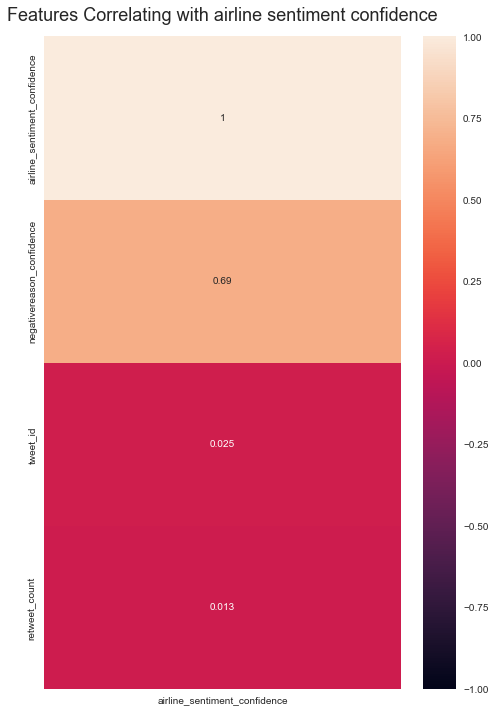

In [37]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['airline_sentiment_confidence']].sort_values(by='airline_sentiment_confidence', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with airline sentiment confidence', fontdict={'fontsize':18}, pad=16)

In [40]:
date = df.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_df = day_df.reset_index()
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
               United          negative               2
2015-02-17     Delta           negative             108
                               positive              69
               Southwest       negative             213
                                                   ... 
2015-02-24     US Airways      positive              16
               United          negative             142
                               positive              25
               Virgin America  negative              10
                               positive              13
Length: 92, dtype: int64

## Text Preparation

In [41]:
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

                 

def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])


 
def check_scores(clf,X_train, X_test, y_train, y_test):

  model=clf.fit(X_train, y_train)
  predicted_class=model.predict(X_test)
  predicted_class_train=model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)


  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))

  print()
  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()
  print(classification_report(y_test,predicted_class)) 
  print() 
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  print()
  print('Are under Precision-Recall curve:', lr_f1)
  
  fpr, tpr, _ = roc_curve(y_test, test_probs)


  ax2.plot(fpr, tpr)
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model


In [48]:
df = df[df['airline_sentiment']!='neutral']
df['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df.head()
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),you ve added commercials to the experience tacky
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),s really aggressive to blast obnoxious enterta...
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),it s a really big bad thing about it
5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),would pay a flight for seats that didn t have ...
6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),nearly every time i fly vx this ear worm won t...


In [53]:
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process)
df.reset_index(drop=True, inplace = True)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),added commercials experience tacky
1,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
2,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing
3,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),would pay flight seats playing really bad thin...
4,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),nearly every time fly vx ear worm go away


In [54]:
df['airline_sentiment'].unique()

array([1, 0], dtype=int64)

## Modeling

### Base SVM Model

In [61]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)

Train confusion matrix is: 
[[6824   31]
 [ 151 1649]]

Test confusion matrix is: 
[[2291   32]
 [ 296  267]]

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      2323
           1       0.89      0.47      0.62       563

    accuracy                           0.89      2886
   macro avg       0.89      0.73      0.78      2886
weighted avg       0.89      0.89      0.87      2886


Train accuracy score:  0.9789716926632005
Test accuracy score:  0.8863478863478863

Train ROC-AUC score:  0.9969059080962801
Test ROC-AUC score:  0.9291493131087764

Are under Precision-Recall curve: 0.6194895591647333
Area under ROC-AUC: 0.804974091622098


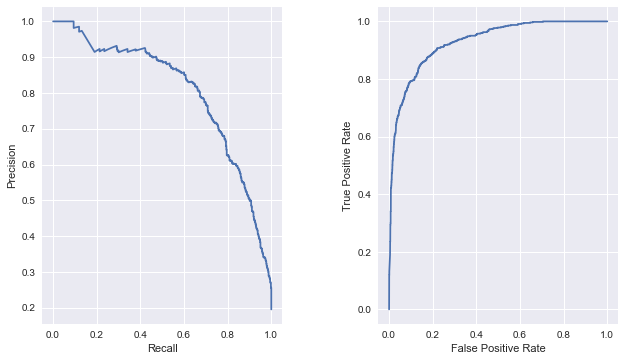

In [70]:
SVM = svm.SVC( probability=True)
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM,x_train, x_test, y_train, y_test)

In [73]:
#Hyperparameter Tuning
parameters ={
    "C":[0.1,1,10],
    "kernel":['linear', 'rbf', 'sigmoid'],
    "gamma":['scale', 'auto']
}



svm_optimal = grid_search(svm.SVC(probability=True), parameters,x_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   6.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   5.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   9.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   9.3s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   5.7s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   5.5s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   6.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   5.7s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   4.3s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   4.2s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   3.8s
[CV] END ..................C=0.1, gamma=auto, ke

Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2272   51]
 [ 245  318]]

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2323
           1       0.86      0.56      0.68       563

    accuracy                           0.90      2886
   macro avg       0.88      0.77      0.81      2886
weighted avg       0.89      0.90      0.89      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8974358974358975

Train ROC-AUC score:  0.9987310154793744
Test ROC-AUC score:  0.9287257168067566

Are under Precision-Recall curve: 0.6824034334763949
Area under ROC-AUC: 0.8075481968430163


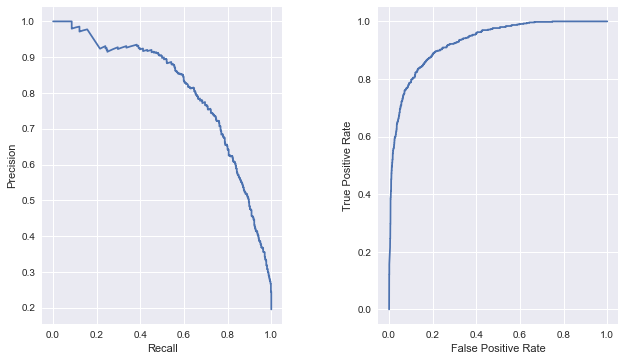

In [74]:
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimal,x_train, x_test, y_train, y_test)

### Random Forest Classifier

Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2215  108]
 [ 238  325]]

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2323
           1       0.75      0.58      0.65       563

    accuracy                           0.88      2886
   macro avg       0.83      0.77      0.79      2886
weighted avg       0.87      0.88      0.87      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8801108801108801

Train ROC-AUC score:  0.9982442661479861
Test ROC-AUC score:  0.8956867344777572

Are under Precision-Recall curve: 0.6526104417670683
Area under ROC-AUC: 0.7441899264879837


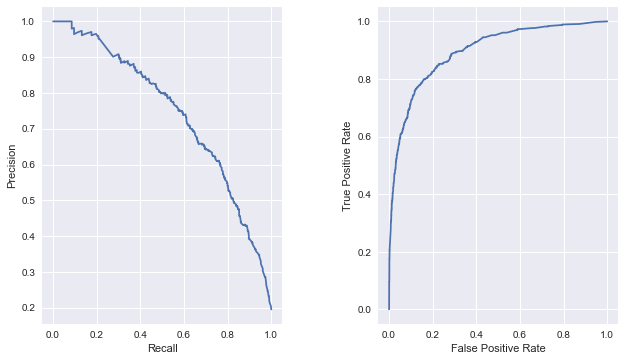

In [75]:
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(RandomForestClassifier(random_state=0).fit(x_train, y_train), x_train,x_test,y_train,y_test)